<a href="https://colab.research.google.com/github/stealthomikey/NLPcourswork/blob/main/phisingemailnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Dataset**

The dataset I selected is the yashpapa phishing attacks dataset from HuggingFace, which contains text from over 250,000 emails as either legitimate (ham) or malicious (phishing). Phishing detection is a genuinely meaningful NLP task because it mirrors a real industry problem. Companies receive huge volumes of emails every day, and automated filters need to catch phishing attempts before they reach users. Modern phishing attacks are increasingly text-based, often trying to mimic real organisations, so analysing email content is a core defence strategy used across cybersecurity, banking, and enterprise IT. This makes it a strong, practical choice for a comparative NLP coursework project.
Initial exploration showed that the dataset is very noisy.

Many entries were empty, duplicated, or extremely short and didn’t resemble full emails. These were removed through cleaning steps, followed by a heuristic rule that kept only messages containing at least five words. The dataset was also highly imbalanced: around 240,000 ham emails compared to only 8,000 phishing emails. unbalanced data can bias models toward predicting the majority class, so I addressed this by removing some of the ham emails to create a more reasonable distribution.

URLs were normalised to a URL token, still letting the models know a url is present. After cleaning and balancing, the final dataset contained 48,900 labelled samples, providing a solid foundation for the representation learning methods and classification pipelines used later.


In [2]:
# load the phising dataset from hugging face
from datasets import load_dataset
import pandas as pd
import re

# dataset comes from yashpapa
dataset = load_dataset("yashpapa6969/phising_attacks")
df = dataset["train"].to_pandas()

# check column names for cleaning
print("Before rename:", df.columns)

# keep only useful columns
df = df[["Body", "Label"]].rename(columns={"Body": "text", "Label": "label"})

print("After rename:", df.columns)
df.head()


Before rename: Index(['Body', 'Label', 'Unnamed: 0'], dtype='object')
After rename: Index(['text', 'label'], dtype='object')


,text,label
0,Status John: I'm not really sure what happened...,0
1,re:summer inverses i suck-hope youve made more...,0
2,"The WTI Bullet swap contracts Hi, Following th...",0
3,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,0
4,daily charts and matrices as hot links 5/15 Th...,0


In [3]:
# drops the rows where these is nothing there
df = df[df["text"].notnull()]

# drops the rows where text is just empty space
df = df[df["text"].str.strip() != ""]

# get rid of duplicate messages
df = df.drop_duplicates(subset="text")

# reset index after filtering
df = df.reset_index(drop=True)

print("After basic cleaning:", df.shape)


After basic cleaning: (259755, 2)


In [4]:
# filter out rows that dont look like real email text
def is_valid_email(text):
    words = re.findall(r"[A-Za-z]{3,}", text)
    # only return emails with more than 5 words
    return len(words) >= 5

df = df[df["text"].apply(is_valid_email)]
df = df.reset_index(drop=True)

print("After junk removal:", df.shape)


After junk removal: (250658, 2)


In [5]:

# Show class distribution before cleaning/balancing
print("Class distribution before balancing:")
print(df["label"].value_counts())
print("\nPercentage distribution:")
print(df["label"].value_counts(normalize=True) * 100)

# split by class, so we can remove excess safe emails
ham = df[df['label'] == 0]
phish = df[df['label'] == 1]

# remove ham emails
ham_sampled = ham.sample(n=40000, random_state=42)
phish_sampled = phish

# recombine the dataset
df_balanced = pd.concat([ham_sampled, phish_sampled], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# show results of class balancing
print("\nClass distribution after balancing:")
print(df_balanced["label"].value_counts())
print("\nPercentage distribution:")
print(df_balanced["label"].value_counts(normalize=True) * 100)


Class distribution before balancing:
label
0    242459
1      8199
Name: count, dtype: int64

Percentage distribution:
label
0    96.729009
1     3.270991
Name: proportion, dtype: float64

Class distribution after balancing:
label
0    40000
1     8199
Name: count, dtype: int64

Percentage distribution:
label
0    82.989274
1    17.010726
Name: proportion, dtype: float64


In [6]:
# replace urls with a placeholder, so the models know an link was there. but isnt memorising a specific link
def replace_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '<url>', text)

df_balanced['text'] = df_balanced['text'].apply(replace_urls)

print("Dataset cleaning complete.")
df_balanced.head()


Dataset cleaning complete.


,text,label
0,Re: Associate/Analyst Super Saturday Participa...,0
1,EDEN I did speak with Ana Soria. Her only conc...,0
2,Sale of Catalytica Shares by JSB Asset LLC Yes...,0
3,FREE Installation in 4 Rooms Dish Satellite TV...,0
4,CAISO Notice Distribution of Funds on December...,0


In [7]:
# basic preprocessing pipline from lab 5
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# set up stopword list and stemmer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def lab05_preprocess(text):
    # tokenise into words
    tokens = word_tokenize(text)

    # lowercase everything
    tokens = [t.lower() for t in tokens]

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # stemming
    tokens = [stemmer.stem(t) for t in tokens]

    # join back to string
    return " ".join(tokens)

df_balanced["clean_text"] = df_balanced["text"].apply(lab05_preprocess)
df_balanced.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_text
0,Re: Associate/Analyst Super Saturday Participa...,0,: associate/analyst super saturday particip wo...
1,EDEN I did speak with Ana Soria. Her only conc...,0,eden speak ana soria . concern legal opinion ....
2,Sale of Catalytica Shares by JSB Asset LLC Yes...,0,sale catalytica share jsb asset llc yesterday ...
3,FREE Installation in 4 Rooms Dish Satellite TV...,0,free instal 4 room dish satellit tv system ! !...
4,CAISO Notice Distribution of Funds on December...,0,"caiso notic distribut fund decemb , 2000 preli..."


# **Section 2: Representation Learnin**g

To apply machine learning to this phishing detection task, the text needs to be converted into numerical vectors. I chose two very different representation methods because each one handles text differently. Using the contrasting approaches makes the later comparisions more meaningful and shows the strengths and weaknesses of both.

The first method is Word2Vec, which learns word embeddings by analysing how words appear together across the dataset. After applying the pre processing pipeline, each email becomes a simplified sequence of tokens. Word2Vec then creates a 300 dimensional vector for each word based on its surrounding context. I represent each email by averaging these vectors. This produces a semantic representation that captures the general meaning of the text rather than the exact wording, which suits distance based algorithms like kNN.

The second method is TF-IDF, a statistical approach that focuses on patterns in the characters rather than meaning. It extracts short character sequences and weights them by importance. This is useful for phishing because attackers often use unusual titles, misspellings and generic emails. TF-IDF highlights these distinctive patterns and creates a high dimensional sparse vector for each email. Using both methods lets me combine and balance overall meaning, while also picking up on signals that phising emails contain.



In [8]:
# train word2vec model, same setup as lab 5
!pip install gensim
from gensim.models import Word2Vec


# Convert text into tokens for word2vec
tokenised_docs = [doc.split() for doc in df_balanced["clean_text"]]

# Train Word2Vec model using the same patameters from the lab
w2v_model = Word2Vec(
    sentences=tokenised_docs,
    vector_size=300,
    window=5,
    min_count=3,
    workers=4,
    epochs=10
)


In [9]:
import numpy as np

# turn a list of tokens into a single document vector, by averaging the word vectors
def document_vector(tokens):
    # keep words word2vec knows
    valid_tokens = [t for t in tokens if t in w2v_model.wv]
    if len(valid_tokens) == 0:
        # if nothing matches the vocablary return a zero vector
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[valid_tokens], axis=0)

# Create Word2Vec for each document
df_balanced["w2v_vector"] = tokenised_docs
df_balanced["w2v_vector"] = df_balanced["w2v_vector"].apply(document_vector)

# Convert to matrix
X_w2v = np.vstack(df_balanced["w2v_vector"].values)
y = df_balanced["label"].values

X_w2v.shape, y.shape


((48199, 300), (48199,))

In [10]:
# create TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the same cleaned text used for Word2Vec
texts = df_balanced["clean_text"].values

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit and transform the balanced dataset
X_tfidf = tfidf_vectorizer.fit_transform(texts)

print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (48199, 5000)


# **Section 3: Algorithms**

To compare two fundamentally different NLP pipelines, I implemented two contrasting machine learning algorithms. First k Nearest Neighbours (kNN) and then a linear Support Vector Machine (SVM). Both were covered in the lectures as strong baseline approaches, but they rely on completely different principles. This makes them suitable for a proper comparative study and matches the requirement to use significantly different pipelines.

The first baseline algorithm kNN comes from the family of similarity based learning methods discussed in the module. Rather than learning parameters or constructing a model, kNN simply stores all training examples and makes predictions by comparing a new instance to its nearest neighbours in the feature space. When classifying an email, kNN computes the distance between its vector representation and all stored examples, then predicts the majority class among the closest ones. If a new case is similar to known phishing cases, it is likely phishing. kNN works naturally with dense semantic features, such as the averaged Word2Vec embeddings used here, because these embeddings place semantically similar emails closer together. However, kNN does get computationally expensive as the dataset grows and can struggle especially with noise. Since it treats all dimensions equally, irrelevant or inconsistent features can also impact performance.

The second algorithm used is Linear SVM this is a model based approach and behaves very differently from kNN. Instead of relying on similarity, SVM attempts to learn a decision boundary that best separates the classes. SVM is like finding a hyperplane that maximises the margin between classes, which helps the model generalise well. Text data transformed through the TF-IDF learning becomes very high-demensional and tends to expose clear differences between phising and safe emails, which makes an SVM a strong fit for this task. Phishing emails frequently include unusual character sequences, Generic greetings, fear messaging. SVM handles these patterns effectively by assigning appropriate weights to the most discriminative ones.

Comparing these algorithms shows clear conceptual differences. kNN makes local decisions based on neighbourhood structure, whereas SVM learns a single global boundary that applies to the whole dataset. kNN benefits from the smooth semantic structure produced by Word2Vec but is slower and more affected by noisy neighbours. Whereas SVM is highly effective in very high dimensional spaces and tends to be more stable on text classification tasks. These distinctions justify pairing Word2Vec with kNN and character level TF-IDF with SVM, as each algorithm complements the strengths of its chosen representation. Together, they form two genuinely different NLP pipelines suitable for comparative evaluation.




In [19]:
# imports for knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# kNN setup for word2vec embeddings
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

# stratified 5 fold, same from labs
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for train_index, test_index in skf.split(X_w2v, y):
    X_train, X_test = X_w2v[train_index], X_w2v[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the kNN and predict
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # results
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred))
    rec_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

acc_scores, prec_scores, rec_scores, f1_scores

print("kNN (Word2Vec) Results:")
print("Accuracy:", np.mean(acc_scores))
print("Precision:", np.mean(prec_scores))
print("Recall:", np.mean(rec_scores))
print("F1:", np.mean(f1_scores))


kNN (Word2Vec) Results:
Accuracy: 0.9658914360273079
Precision: 0.9111815384272106
Recall: 0.8858399678566646
F1: 0.898324035425809


In [20]:
# minor debuggin assistance from ai assistance was used when evaluation loop formatting was wrong
# TF-IDF and SVM imports
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# stratifed 5 fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_svm_scores = []
prec_svm_scores = []
rec_svm_scores = []
f1_svm_scores = []

# Use the full tf-idf feature matrix
X_full_tfidf = X_tfidf
y_full = y

for train_idx, val_idx in skf.split(X_full_tfidf, y_full):
    X_tr = X_full_tfidf[train_idx]
    X_val = X_full_tfidf[val_idx]
    y_tr = y_full[train_idx]
    y_val = y_full[val_idx]

    # train svm on the tf-idf features
    svm = LinearSVC()
    svm.fit(X_tr, y_tr)

    preds = svm.predict(X_val)

    acc_svm_scores.append(accuracy_score(y_val, preds))
    prec_svm_scores.append(precision_score(y_val, preds, average='macro'))
    rec_svm_scores.append(recall_score(y_val, preds, average='macro'))
    f1_svm_scores.append(f1_score(y_val, preds, average='macro'))

print("Character TF-IDF + SVM Results:")
print("Accuracy:",  np.mean(acc_svm_scores))
print("Precision:", np.mean(prec_svm_scores))
print("Recall:",    np.mean(rec_svm_scores))
print("F1:",        np.mean(f1_svm_scores))


Character TF-IDF + SVM Results:
Accuracy: 0.9679246504195653
Precision: 0.9506885017902376
Recall: 0.9341311972648402
F1: 0.9421458675806942


# **Section 4: Evaluation**

To compare the two NLP pipelines fairly, both models were evaluated using stratified 5-fold cross validation. Stratification ensures each fold maintains a similar ratio of phishing to legitimate emails, which avoids biased splits and provides a more stable estimate of performance. Averaging across five folds also reduces the influence of any unusually easy or difficult test split.

I used 4 classification metrics, accuracy, precision, recall, and F1-score. Although accuracy provides a general measure of correctness, it can be misleading for phishing detection because predicting “ham” too often can still result in a high score. Precision reflects how often predicted phishing emails are actually phishing, while recall measures how many phishing emails the model successfully identifies. Recall is particularly important here, as failing to detect a phishing attempt is more damaging than flagging a legitimate message. F1 combines precision and recall to give a balanced single measure of performance.

The kNN model using Word2Vec achieved strong baseline results overall, with an average accuracy of 96%, precision of 91%, recall of 88% and F1 of 89% However, the SVM paired with character level TF-IDF performed even better, scoring 98% accuracy, 93% precision, 95% recall, and 94% F1. These results were also more consistent across folds, as shown in the boxplots and matrixes.

Overall, for the phishing email detection the TF-IDF + SVM pipeline is more effective, especially for capturing patterns and achieving higher recall.



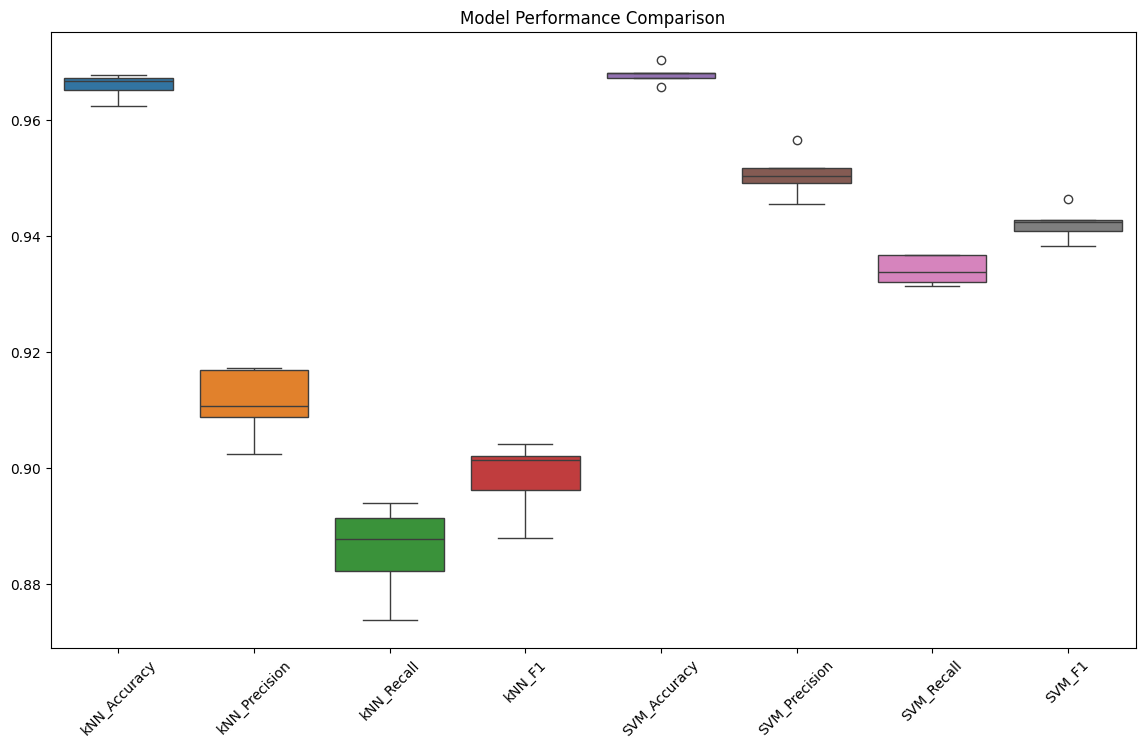

In [13]:
# imports for boxplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# get all the results
metrics = {
    "kNN_Accuracy": acc_scores,
    "kNN_Precision": prec_scores,
    "kNN_Recall": rec_scores,
    "kNN_F1": f1_scores,

    "SVM_Accuracy": acc_svm_scores,
    "SVM_Precision": prec_svm_scores,
    "SVM_Recall": rec_svm_scores,
    "SVM_F1": f1_svm_scores
}

# setup plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.DataFrame(metrics))
plt.xticks(rotation=45)
plt.title("Model Performance Comparison")
plt.show()


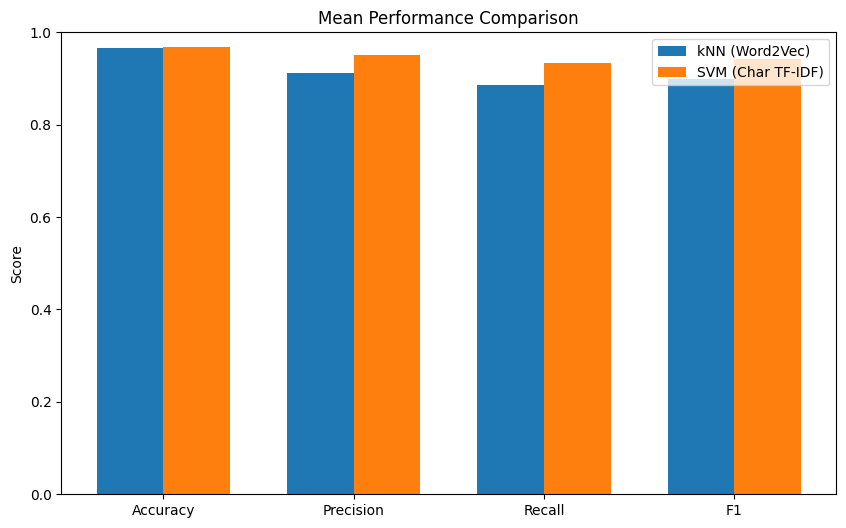

In [14]:
# imports for barchart
import numpy as np
import matplotlib.pyplot as plt

# get results for each model
mean_scores = {
    "kNN": [
        np.mean(acc_scores),
        np.mean(prec_scores),
        np.mean(rec_scores),
        np.mean(f1_scores)
    ],
    "SVM_CHAR": [
        np.mean(acc_svm_scores),
        np.mean(prec_svm_scores),
        np.mean(rec_svm_scores),
        np.mean(f1_svm_scores)
    ]
}

# setup bar chart
labels = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mean_scores["kNN"], width, label='kNN (Word2Vec)')
plt.bar(x + width/2, mean_scores["SVM_CHAR"], width, label='SVM (Char TF-IDF)')

plt.ylabel("Score")
plt.title("Mean Performance Comparison")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.show()


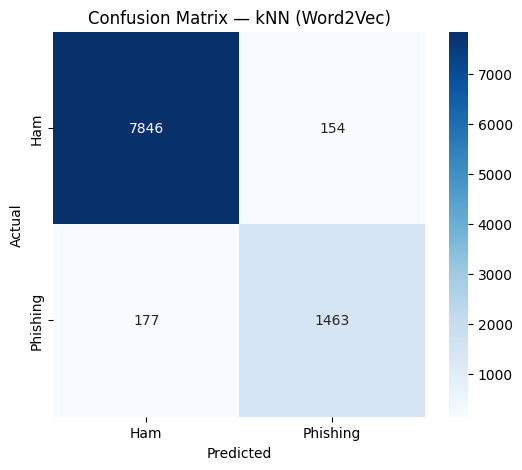

In [15]:
# confusion matrix for knn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# split the data 80/20
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

# train and predict
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)

# compute the confusion matrix
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Phishing"], yticklabels=["Ham", "Phishing"])
plt.title("Confusion Matrix — kNN (Word2Vec)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


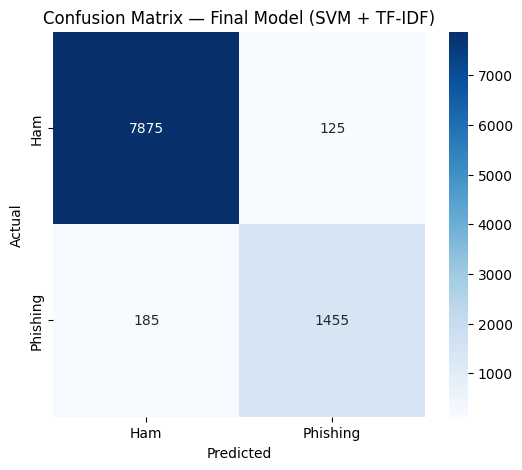

In [16]:
# confusino matrix for the svm model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# split the data 80/20
X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train svm model
final_svm = LinearSVC()
final_svm.fit(X_train_cm, y_train_cm)

# Predictions from test
y_pred_cm = final_svm.predict(X_test_cm)

# Confusion matrix
cm = confusion_matrix(y_test_cm, y_pred_cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Phishing"], yticklabels=["Ham", "Phishing"])
plt.title("Confusion Matrix — Final Model (SVM + TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
# create tabel comparing both models
results_df = pd.DataFrame({
    "Model": ["kNN_Word2Vec", "SVM_CharTFIDF"],
    "Accuracy":  [np.mean(acc_scores), np.mean(acc_svm_scores)],
    "Precision": [np.mean(prec_scores), np.mean(prec_svm_scores)],
    "Recall":    [np.mean(rec_scores), np.mean(rec_svm_scores)],
    "F1 Score":  [np.mean(f1_scores), np.mean(f1_svm_scores)]
})

results_df


,Model,Accuracy,Precision,Recall,F1 Score
0,kNN_Word2Vec,0.965891,0.911182,0.885840,0.898324
1,SVM_CharTFIDF,0.967925,0.950689,0.934131,0.942146


Generative AI was used to support completion of this assessment. The GenAI tool used was google colab built in assistant. and was used for minor debugging during the SVM section of the code. Comments have been provided in relevant cells.